In [1]:
# Necessary when connecting to a jupyterhub kernel running on daint via VScode. NOT required otherwise

import os

new_path = '/users/ajayaraj/scratch/tests/qtpyt-tests/AuBDA13CH2'
os.chdir(new_path)


In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from gpaw import restart
from gpaw.lcao.pwf2 import LCAOwrap
from gpaw.lcao.tools import remove_pbc
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from qtpyt.basis import Basis
from qtpyt.lo.tools import rotate_matrix, subdiagonalize_atoms, cutcoupling
from ase.io import read
from qtpyt.basis import Basis
from qtpyt.block_tridiag import graph_partition, greenfunction
from qtpyt.surface.principallayer import PrincipalSelfEnergy
from qtpyt.surface.tools import prepare_leads_matrices
from qtpyt.tools import remove_pbc, rotate_couplings
from copy import deepcopy
from qtpyt.projector import ProjectedGreenFunction
from qtpyt.hybridization import Hybridization
from qtpyt.continued_fraction import get_ao_charge
from scipy.linalg import eigvalsh
from qtpyt.base.selfenergy import DataSelfEnergy as BaseDataSelfEnergy
from qtpyt.projector import expand

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
from __future__ import annotations

from scipy.optimize import root, linearmixing
from scipy.interpolate import interp1d
from ase.io import read

from edpyt.nano_dmft import Gfloc, Gfimp as nanoGfimp
from edpyt.dmft import SpinGfimp, Gfimp, DMFT, Converged

from edpyt.observs import get_occupation
from edpyt.cotools import draw_feynman_dyson_orbital, draw_spin_density
from edpyt.dmft import FailedToConverge

### Helper functions

In [4]:
def get_species_indices(atoms,species):
    indices = []
    for element in species:
        element_indices = atoms.symbols.search(element)
        indices.extend(element_indices)
    return sorted(indices)

def distance(delta):
    global delta_prev
    delta_prev[:] = delta
    return dmft.distance(delta)

def save_sigma(sigma_diag,outputfile):
    L, ne = sigma_diag.shape
    sigma = np.zeros((ne, L, L), complex)
    
    def save(spin):
        for diag, mat in zip(sigma_diag.T, sigma):
            mat.flat[::(L + 1)] = diag
        np.save(outputfile, sigma)
        
    for spin in range(1):
        save(spin)
        
class DataSelfEnergy(BaseDataSelfEnergy):
    """Wrapper"""

    def retarded(self, energy):
        return expand(S_molecule, super().retarded(energy), idx_molecule)


def load(filename):
    return DataSelfEnergy(energies, np.load(filename))

def run(outputfile):

    global suffix

    T = np.empty(energies.size)

    for e, energy in enumerate(energies):
        T[e] = gf.get_transmission(energy)

    np.save(outputfile, (energies,T.real))

### Control parameters

In [5]:
GPWDEVICEDIR = 'dft/device/'
BRIDGE_SPECIES = ("N", "C", "H")
GPWLEADSDIR = 'dft/leads/'

In [6]:
lowdin = True
cc_path = Path(GPWDEVICEDIR)
pl_path = Path(GPWLEADSDIR)
gpwfile = f'{cc_path}/scatt.gpw'

atoms, calc = restart(gpwfile, txt=None)
fermi = calc.get_fermi_level()
nao_a = np.array([setup.nao for setup in calc.wfs.setups])
basis = Basis(atoms, nao_a)

lcao = LCAOwrap(calc)
H_lcao = lcao.get_hamiltonian()
S_lcao = lcao.get_overlap()
H_lcao -= fermi * S_lcao


Condition number: 2.8e+04


In [7]:
bridge_indices = get_species_indices(atoms, BRIDGE_SPECIES)
basis_bridge = basis[bridge_indices]
bridge_orbital_indices = basis_bridge.get_indices()
bridge_start = bridge_orbital_indices[0]
bridge_end = bridge_orbital_indices[-1]

In [8]:
H_leads_lcao, S_leads_lcao = np.load(pl_path / 'hs_pl_k.npy')

basis_dict = {'Au': 9, 'H': 5, 'C': 13, 'N': 13}

leads_atoms = read(pl_path / 'leads.xyz')
leads_basis = Basis.from_dictionary(leads_atoms, basis_dict)

device_atoms = read(cc_path / 'scatt.xyz')
device_basis = Basis.from_dictionary(device_atoms, basis_dict)

nodes = [0,810,1116,1278,1584,2394]

# Define energy range and broadening factor for the Green's function calculation
de = 0.2
energies = np.arange(-3., 3. + de / 2., de).round(7)
eta = 1e-3

# Define the number of repetitions (Nr) and unit cell repetition in the leads
Nr = (1, 5, 3)
unit_cell_rep_in_leads = (5, 5, 3)

### Subdiagonalize C, N and H of LCAO Hamiltonian (Hamiltonian obtained directly from gpaw)

In [9]:
# Perform subdiagonalization
SUBDIAG_SPECIES = ("C", "N", "H")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate matrices
H_sudiagonalized = rotate_matrix(H_lcao, Usub)[None, ...]
S_sudiagonalized = rotate_matrix(S_lcao, Usub)[None, ...]
H_sudiagonalized = H_sudiagonalized.astype(np.complex128)
S_sudiagonalized = S_sudiagonalized.astype(np.complex128)


In [10]:
# Prepare the k-points and matrices for the leads (Hamiltonian and overlap matrices)
kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao, S_leads_lcao, unit_cell_rep_in_leads, align=(0, H_sudiagonalized[0, 0, 0]))

# Remove periodic boundary conditions (PBC) from the device Hamiltonian and overlap matrices
remove_pbc(device_basis, H_sudiagonalized)
remove_pbc(device_basis, S_sudiagonalized)

# Initialize self-energy list for left and right leads
self_energy = [None, None, None]
self_energy[0] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr)
self_energy[1] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr, id='right')

# Rotate the couplings for the leads based on the specified basis and repetition Nr
rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)

# Tridiagonalize the device Hamiltonian and overlap matrices based on the partitioned nodes
hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(nodes, H_sudiagonalized[0], S_sudiagonalized[0])

# Initialize the Green's function solver with the tridiagonalized matrices and self-energies
gf = greenfunction.GreenFunction(hs_list_ii,
                                 hs_list_ij,
                                 [(0, self_energy[0]),
                                  (len(hs_list_ii) - 1, self_energy[1])],
                                 solver='dyson',
                                 eta=eta)



### Define active region and the Green's function for the active region

In [11]:
# Extract the basis for the subdiagonalized region and get their indices
basis_subdiag_region = basis[subdiag_indices]
index_subdiag_region = basis_subdiag_region.get_indices()

# Define the active region within the subdiagonalized species
active = {'C': [3],'N': [3]}
extract_active_region = basis_subdiag_region.extract().take(active)
index_active_region = index_subdiag_region[extract_active_region]

gfp = ProjectedGreenFunction(gf, index_active_region)
hyb = Hybridization(gfp)

In [12]:
data_folder = 'output'

# Create the folder if it doesn't exist
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

energies = np.arange(-3., 3. + de / 2., de).round(7)
n_A = len(index_active_region)
# Save the files inside the folder
HB = np.empty((energies.size, n_A, n_A), dtype=complex)

for e, energy in enumerate(energies):
    HB[e] = hyb.retarded(energy)

filename = os.path.join(data_folder, 'hybridization.bin')
with open(filename,'wb') as f:
    HB.tofile(f)


In [13]:
# Save other data inside the folder
np.save(os.path.join(data_folder, 'energies.npy'), energies + 1.j * eta)

# Effective Hamiltonian
Heff = (hyb.H + hyb.retarded(0.)).real
np.save(os.path.join(data_folder, 'hamiltonian.npy'), hyb.H)
np.save(os.path.join(data_folder, 'effective_hamiltonian.npy'), Heff)
np.save(os.path.join(data_folder, 'eigvals_Heff.npy'), eigvalsh(Heff, gfp.S))

In [15]:
# Matsubara
gf.eta = 0.
assert self_energy[0].eta == 0.
assert self_energy[1].eta == 0.
ne = 30
beta = 70.
matsubara_energies = 1.j * (2 * np.arange(ne) + 1) * np.pi / beta
HB = np.empty((matsubara_energies.size, n_A, n_A), dtype=complex)

for e, energy in enumerate(matsubara_energies):
    HB[e] = hyb.retarded(energy)

# Save the Matsubara hybrid data
filename = os.path.join(data_folder, 'matsubara_hybridization.bin')
with open(filename,'wb') as f:
    HB.tofile(f)


np.save(os.path.join(data_folder, 'occupancies.npy'), get_ao_charge(gfp))
np.save(os.path.join(data_folder, 'matsubara_energies.npy'), matsubara_energies)


### DMFT

In [16]:
occupancy_goal = np.load(f'{data_folder}/occupancies.npy')

L = occupancy_goal.size

z_ret = np.load(f'{data_folder}/energies.npy')
z_mats = np.load(f'{data_folder}/matsubara_energies.npy')

eta = z_ret[0].imag
beta = np.pi / (z_mats[0].imag)

hyb_ret = np.fromfile(f'{data_folder}/hybridization.bin', complex).reshape(z_ret.size, L, L)
hyb_mats = np.fromfile(f'{data_folder}/matsubara_hybridization.bin',
                       complex).reshape(z_mats.size, L, L)

_HybRet = interp1d(z_ret.real,
                   hyb_ret,
                   axis=0,
                   bounds_error=False,
                   fill_value=0.)
HybRet = lambda z: _HybRet(z.real)

_HybMats = interp1d(z_mats.imag,
                    hyb_mats,
                    axis=0,
                    bounds_error=False,
                    fill_value=0.)
HybMats = lambda z: _HybMats(z.imag)
HybZro = lambda z: np.zeros((L, z.size), complex)

H = np.load(f'{data_folder}/hamiltonian.npy').real
S = np.eye(L)

idx_neq = np.arange(L)
idx_inv = np.arange(L)

U = 4.  # Interaction
V = np.eye(L) * U


In [17]:
double_counting = np.diag(V.diagonal() * (occupancy_goal - 0.5))
gfloc = Gfloc(H - double_counting, np.eye(L), HybMats, idx_neq, idx_inv)

nimp = gfloc.idx_neq.size
gfimp: list[Gfimp] = []
nbaths = 4
for i in range(nimp):
    gfimp.append(Gfimp(nbaths, z_mats.size, V[i, i], beta))

gfimp = nanoGfimp(gfimp)

occupancy_goal = occupancy_goal[gfloc.idx_neq]

dmft = DMFT(gfimp,
            gfloc,
            occupancy_goal,
            max_iter=200,
            tol=27,
            adjust_mu=True,
            alpha=0.)

Sigma = lambda z: np.zeros((nimp, z.size), complex)
delta = dmft.initialize(V.diagonal().mean(), Sigma, mu=0.)
delta_prev = delta.copy()

try:
    root(distance, delta_prev, method='broyden1')
except Converged:
    pass

np.save(f'{data_folder}/dmft_delta.npy', delta_prev)
open(f'{data_folder}/mu.txt', 'w').write(str(gfloc.mu))

_Sigma = lambda z: -double_counting.diagonal()[:, None] - gfloc.mu + gfloc.Sigma(z)[idx_inv]


Iteration :  0
Occupation : 11.70173 | Chemical potential : 0.20129 | Error : 27.82906
Iteration :  1
Occupation : 11.70173 | Chemical potential : 0.11855 | Error : 37.52028
Iteration :  2
Occupation : 11.70173 | Chemical potential : 0.22953 | Error : 28.43034
Iteration :  3
Occupation : 11.70173 | Chemical potential : 0.23252 | Error : 32.75922
Iteration :  4
Occupation : 11.70173 | Chemical potential : 0.21210 | Error : 34.29756
Iteration :  5
Occupation : 11.70173 | Chemical potential : 0.20789 | Error : 33.82716
Iteration :  6
Occupation : 11.70173 | Chemical potential : 0.20704 | Error : 33.73256
Iteration :  7
Occupation : 11.70173 | Chemical potential : 0.20676 | Error : 33.72338
Iteration :  8
Occupation : 11.70173 | Chemical potential : 0.27988 | Error : 19.05961


In [18]:
dmft_sigma_file = f"{data_folder}/dmft_sigma.npy"
save_sigma(_Sigma(z_ret),dmft_sigma_file)

### Transmission function

In [19]:
imb = 2  # index of molecule block
S_molecule = hs_list_ii[imb][1]  # overlap of molecule
idx_molecule = index_active_region - nodes[imb]  # indices of active region w.r.t molecule


In [20]:
# DFT
outputfile = f"{data_folder}/dft_transmission.npy"
run(outputfile)

self_energy[2] = load(dmft_sigma_file)
gf.selfenergies.append((imb, self_energy[2]))

outputfile = f"{data_folder}/dmft_transmission.npy"
run(outputfile)
gf.selfenergies.pop()

(2, <__main__.DataSelfEnergy at 0x1554627aabe0>)

In [21]:
# Define the path to the reference data for transmission
ref_path = "published_reference/transmission"

# Load the reference LCAO transmission data from a file, where reference is the data from "Strong correlation effect paper"
E1, Tref_dft = np.load(f"{ref_path}/ET_dft.npy")

# Load the reference dmft transmission data from a file, where reference is the data from "Strong correlation effect paper"
E2, Tref_dmft = np.load(f"{ref_path}/ET_dmft.npy")

E3, T_dft = np.load(f"{data_folder}/dft_transmission.npy")

E4, T_dmft = np.load(f"{data_folder}/dmft_transmission.npy")

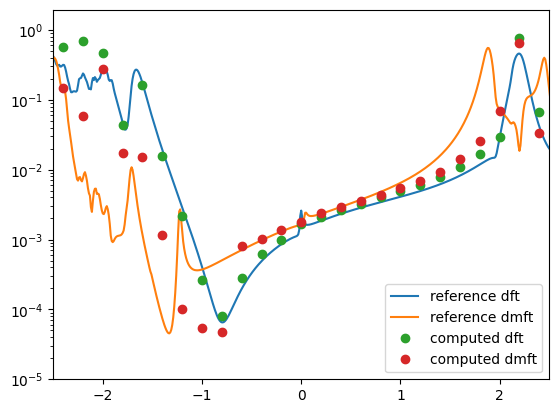

In [23]:
# Plot the reference LCAO transmission data
plt.plot(E1, Tref_dft, label="reference dft")

plt.plot(E2, Tref_dmft, label="reference dmft")

# Plot the computed LCAO transmission data
plt.plot(E3, T_dft, 'o', label="computed dft")

plt.plot(E4, T_dmft, 'o', label="computed dmft")

# Set the y-axis to a logarithmic scale to better visualize the transmission data
plt.yscale("log")
plt.xlim(-2.5,2.5)
plt.ylim(bottom=1e-5)
plt.legend()